<a href="https://colab.research.google.com/github/taobeto/neuroscience/blob/main/Carlos_Alberto_Pena_Sanchez_Lab_Curvas_f_I_VClase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Hodgkin y Huxley

# Cálculo de Curvas f-I

Este notebook tiene como objetivo calcular las curvas $ f-I $ (frecuencia-corriente), así como aprender a hacer análisis de tiempos de disparo.

### Ejercicio 1:

Construir la curva f-I del modelo de HH con los parámetros dados en la clase anterior. A qué tipo de clase de excitabilidad corresponde el modelo de HH con los parámetros estudiados?

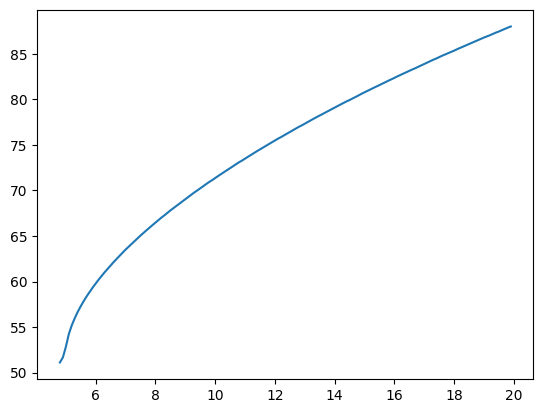

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


def Iext(t, Iextesco):
  if t >= 0 and t <= 300 :
    Iext = Iextesco
  else:
    Iext = 0
  return Iext


def Hodgkin_Huxley(t, X, Iextesco, Cm, gna, gk, gl, Ena, Ek, El):

  V = X[0]
  n = X[1]
  m = X[2]
  h = X[3]


  I_ext= Iext(t, Iextesco)

  an = 0.01*(V+55)/(1-np.exp(-(V+55)/10))
  bn = 0.125*np.exp(-(V+65)/80)
  am = 0.1*(V+40)/(1-np.exp(-(V+40)/10))
  bm = 4*np.exp(-(V+65)/18)
  ah = 0.07*np.exp(-(V+65)/20)
  bh = 1/(1+np.exp(-(V+35)/10))


  ninf = an/(an+bn)
  tn = 1/(an+bn)

  minf = am/(am+bm)
  tm = 1/(am+bm)

  hinf = ah/(ah+bh)
  th = 1/(ah+bh)

  dndt = (ninf-n)/tn
  dmdt = (minf-m)/tm
  dhdt =(hinf-h)/th

  Ina = gna*m**3*h*(V-Ena)
  Ik = gk*n**4*(V-Ek)
  Il = gl*(V-El)


  dVdt = (I_ext -(Ina + Ik + Il))/Cm
  return [dVdt, dndt, dmdt, dhdt]


frecuencias = []
Imedidas = []
tspan = [0, 300]
X0 = [-65,0.3365,0.05885,0.5519]
for i in range(200):
  Iextesco = 0.1*i
  Iextesco,Cm,gna,gk,gl,Ena,Ek,El = Iextesco,1,120,36,0.3,50,-77,-50
  solucion = solve_ivp(Hodgkin_Huxley, tspan, X0,
                    args = (Iextesco,Cm,gna,gk,gl,Ena,Ek,El), dense_output = True, rtol =  10**-6)

  tdenso = np.linspace(tspan[0], tspan[-1], 5000)
  V, n, m, h = solucion.sol(tdenso)

  peakID,_ = find_peaks(V,height=10)
  tiempos_spike = tdenso[peakID]

  tiempos_spike = tdenso[peakID]
  valor_spike = V[peakID]
  if len(valor_spike) < 2:
    continue
  else:
    Imedidas.append(Iextesco)
    intervalos_spike = np.diff(tiempos_spike)
    periodo_spike = np.mean(intervalos_spike)*0.001
    frecuencia_spike = 1/periodo_spike
    frecuencias.append(frecuencia_spike)

plt.plot(Imedidas, frecuencias)
plt.show()




### Ejercicio 2:

A continuación se le presenta un experimento real de electorfisología en el que su colega biólogo ha hecho un experimento aplicando un protocolo de estimulación a una neurona, consistente en varios valores de corriente constante. Su colega le solicita que le indique si la neurona que ha registrado es de tipo I o tipo II.

Realice el análisis para determinarlo. Para ello

1. Compute la curva $f - I$ de esta neurona
2. Muestre dos curvas representativas mostrando cómo es la traza de tiempo del voltaje para una corriente subumbral y una supraumbral.


El dipsoitivo que se usa para hacer registros electrofisiológicos almacena los datos en formato *abf*, para poder leer los datos ejecute el siguiente *snippet*

In [ ]:
!pip install pyabf
import pyabf
abf = pyabf.ABF('SpikesAndBursts_PFC_Pvalb_APs_01.abf')
print(abf)

ABF (v2.6) with 2 channels (mV, pA), sampled at 10.0 kHz, containing 13 sweeps, having no tags, with a total length of 0.65 minutes, recorded with protocol "CC_20pA_100_340pA_500ms".


Como puede notar el objeto abf importado contiene información sobre 2 canales. Uno mide el potencial de membrana, mientras el otro registra la corriente aplicada, ambas en función del tiempo, con una frecuencia de muestreo de 10kHz. El experimento consiste en 13 *sweeps* o protocolos diferentes. Para acceder a la información del *sweep* i-ésimo, deberá llamar el método

abf.setSweep(i)

Una vez establecido el sweep que desea analizar la información requerida la encontrará en los siguiente atributos:

- tiempo -> abf.sweepX
- voltaje -> abf.sweepY
- corriente -> abf.sweepC

In [ ]:
# TODO